How should we handle a stochastic model? In computing the sensitivity measures, is it sufficient to run the model *once* for each sample parameter set, should we use an average over many runs for each sample parameter set, or maybe even just a few runs for each parameter set?

# Cumulative new infections of a general epidemic

The stochastic general epidemic model with counts $(S, I, R, C)$ of the number of people susceptible, infectious, recovered, and cumulative new infections, has events:

* Birth: $(S, I, R, C) \to (S + 1, I, R, C)$ with hazard $\mu N$;
* Death of a susceptible: $(S, I, R, C) \to (S - 1, I, R, C)$ with hazard $\mu S$;
* Death of an infectious: $(S, I, R, C) \to (S, I - 1, R, C)$ with hazard $\mu I$;
* Death of a recovered: $(S, I, R, C) \to (S, I, R - 1, C)$ with hazard $\mu R$;
* Infection: $(S, I, R, C) \to (S - 1, I + 1, R, C + 1)$ with hazard $\frac{\beta I}{N} S$; and
* Recovery: $(S, I, R, C) \to (S, I - 1, R + 1, C)$ with hazard $\gamma I$;

where $N = S + I + R$.

The basic reproduction number is
$$R_0 = \frac{\beta}{\gamma + \mu}.$$

When $R_0 > 1$, we will use the endemic equilibrium of the deterministic model
$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= \mu N - \frac{\beta I}{N} S - \mu S,\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta I}{N} S - \gamma I - \mu I,\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - \mu R,
\end{aligned}$$
as the expected value of a multinomial distribution to determine the initial condition for the stochastic model:
$$\left(S(0), I(0), R(0), C(0)\right)
= \mathrm{Multinomial}(N_0, p),$$
where
$$p = \left(\frac{1}{R_0},
            \frac{\mu}{\beta}\left(R_0 - 1\right),
            \frac{\gamma}{\beta}\left(R_0 - 1\right),
            0\right),$$
and $N_0$ is the initial population size.
We will resample from this multinomial until we get an initial condition with $I(0) > 0$.

We will simulate the stochastic model using the Gillespie algorithm.

For each simulation, we will find the extinction time, the first time with $I(t) = 0$.

In [1]:
import joblib
import numpy
import pandas
from scipy import stats

import sensitivity_analysis

In [2]:
def get_R_0(beta, gamma, mu, N):
    return beta / (gamma + mu)


def initial_state(beta, gamma, mu, N_0, rng):
    '''Generate a random initial `state`.'''
    R_0 = get_R_0(beta, gamma, mu, N_0)
    if R_0 > 1:
        # The endemic equilibrium.
        equilibrium = numpy.array((
            1 / R_0 * N_0,                   # S                 
            mu / beta * (R_0 - 1) * N_0,     # I
            gamma / beta * (R_0 - 1) * N_0,  # R
            0,                               # C
        ))
    else:
        # The disease-free equilibrium.
        equilibrium = numpy.array((
            N_0,  # S                 
            0,    # I
            0,    # R
            0,    # C
        ))
    # Fraction in each state.
    p = equilibrium / equilibrium.sum()
    # If R_0 > 1, resample to get I > 0.
    while True:
        state = rng.multinomial(N_0, p)
        (S, I, R, C) = state
        if (R_0 <= 1) or (I > 0):
            break
    return state


# The transitions that can occur and how they change `state`.
transitions = numpy.array((
    (+1, 0, 0, 0),    # Birth
    (-1, 0, 0, 0),    # Death of S
    (0, -1, 0, 0),    # Death of I
    (0, 0, -1, 0),    # Death of R
    (-1, +1, 0, +1),  # Infection
    (0, -1, +1, 0),   # Recovery
))


def update_hazards(hazards, t, state, beta, gamma, mu):
    '''Update `hazards` for the current state and time.'''
    (S, I, R, C) = state
    N = S + I + R
    # `hazards` must be in the same order as `transitions`.
    hazards[:] = (
        mu * N,            # Birth
        mu * S,            # Death of S
        mu * I,            # Death of I
        mu * R,            # Death of R
        beta * I / N * S,  # Infection
        gamma * I,         # Recovery
    )


def stop(t, state, t_end):
    '''The stopping condition for the simulation.'''
    (S, I, R, C) = state
    return (t >= t_end) or (I == 0)


def get_cum_infections(beta, gamma, mu, N_0=1000, t_end=1000, seed=None):
    '''Simulate the cumulative new infections for a stochastic general SIR model.'''
    rng = numpy.random.default_rng(seed)
    t = 0
    state = initial_state(beta, gamma, mu, N_0, rng)
    # Build empty vectors that will get updated in each step.
    n_transitions = len(transitions)
    hazards = numpy.empty(n_transitions, dtype=float)
    hazards_scaled = numpy.empty(n_transitions, dtype=float)
    while not numpy.isposinf(t) and not stop(t, state, t_end):
        update_hazards(hazards, t, state, beta, gamma, mu)
        # Find the time to the next event.
        hazard_total = hazards.sum()
        if hazard_total > 0:
            t += rng.exponential(1 / hazard_total)
            # Find which of the events occurred.
            # Scale the hazards so that they sum to 1.
            hazards_scaled[:] = hazards / hazard_total
            which = rng.choice(n_transitions, p=hazards_scaled)
            state += transitions[which]
        else:  # hazard_total == 0
            # Check that we don't have hazard_total < 0.
            assert numpy.isclose(hazard_total, 0)
            t = numpy.PINF
    (S, I, R, C) = state
    return C

In [3]:
get_cum_infections(0.012, 0.01, 0.001, seed=1)

159

Let's take the parameters to be the random variables
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4),\\
\gamma &\sim \Gamma(0.01, 4),\\
\mu &\sim \Gamma(0.001, 4),
\end{aligned}$$
where $\Gamma(a, k)$ is the gamma random variable with mean $a$ and shape $k$.

In [4]:
def gamma_from_mean_and_shape(mean, shape):
    '''Generate a gamma random variable with the given mean and shape.'''
    scale = mean / shape
    return stats.gamma(shape, scale=scale)


parameters = dict(
    beta=gamma_from_mean_and_shape(0.03, 4),
    gamma=gamma_from_mean_and_shape(0.01, 4),
    mu=gamma_from_mean_and_shape(0.001, 4),
)

In [5]:
def get_seed(seed_seq):
    '''Helper function to spawn a single seed from a `numpy.random.SeedSequence()`.'''
    return seed_seq.spawn(1)[0]


def run_many(model, samples, seed=None, n_jobs=-1):
    '''Run `model` for each of the `samples` parameter sets in parallel.'''
    if isinstance(seed, numpy.random.SeedSequence):
        seed_seq = seed
    else:
        seed_seq = numpy.random.SeedSequence(seed)
    with joblib.Parallel(n_jobs=n_jobs) as parallel:
        if isinstance(samples, pandas.DataFrame):
            return parallel(
                joblib.delayed(model)(**sample, seed=get_seed(seed_seq))
                for (_, sample) in samples.iterrows())
        else:
            return parallel(
                joblib.delayed(model)(*sample, seed=get_seed(seed_seq))
                for sample in samples)

In [6]:
seed_seq = numpy.random.SeedSequence(1)
samples = sensitivity_analysis.samples_Latin_hypercube(parameters,
                                                       n_samples=100,
                                                       seed=get_seed(seed_seq))
cum_inf = run_many(get_cum_infections,
                   samples,
                   seed=get_seed(seed_seq))

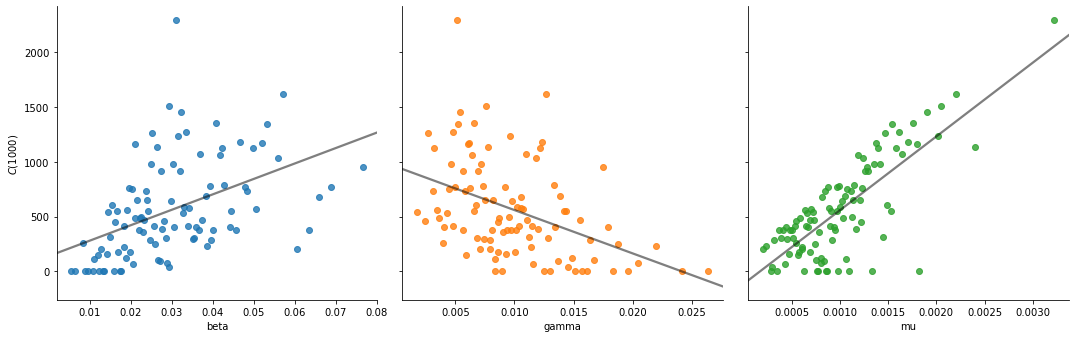

In [7]:
fg = sensitivity_analysis.scatterplots_samples(samples, cum_inf)
_ = fg.set_ylabels(r'$C(1000)$')

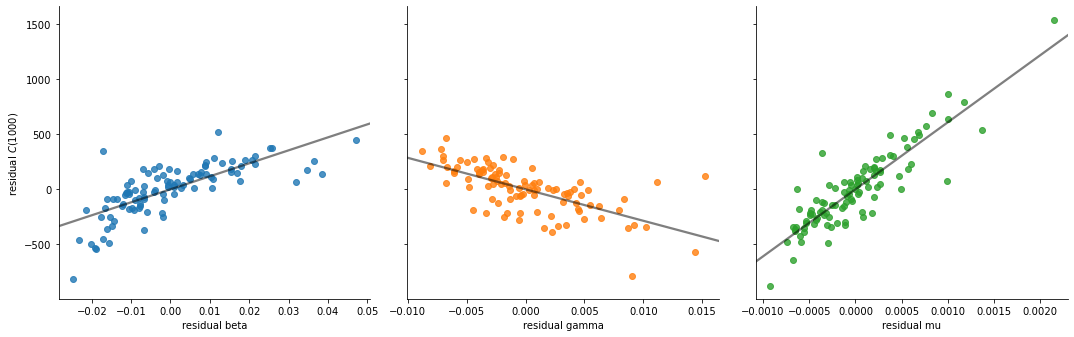

In [8]:
fg = sensitivity_analysis.residualplots_samples(samples, cum_inf)
_ = fg.set_ylabels(r'residual $C(1000)$')

In [9]:
table = {}
table[r'$\beta_{\sigma}$'] = sensitivity_analysis.linreg_coefficients_samples(
    samples, cum_inf)
table[r'$\rho_{\mathrm{partial\ rank}}$'] = sensitivity_analysis.PRCC_samples(
    samples, cum_inf)
table = pandas.DataFrame(table)
table

,$\beta_{\sigma}$,$\rho_{\mathrm{partial\ rank}}$
beta,0.390410,0.796522
gamma,-0.316565,-0.724649
mu,0.707997,0.843863
